In [1]:
import os
import torch
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import copy
from torch.optim import lr_scheduler

In [2]:
!unzip cnn_dataset.zip -d /content/cnn_dataset/
dataset_path = "/content/cnn_dataset"  # Replace with actual dataset path

# Define image transformations for loading (adjust if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a uniform size
    transforms.ToTensor()  # Convert to PyTorch tensor
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Get class names and count images per class
class_names = dataset.classes
class_counts = Counter([dataset.targets[i] for i in range(len(dataset))])

# Convert counts to DataFrame for easy visualization
df = pd.DataFrame({'Class': class_names, 'Image Count': [class_counts[i] for i in range(len(class_names))]})

# Display dataset statistics
print(f"Total Images: {len(dataset)}")
print(f"Number of Classes: {len(class_names)}")
print("\nClass Distribution:\n", df)

Streaming output truncated to the last 5000 lines.
  inflating: /content/cnn_dataset/vehicles/5505.jpg  
  inflating: /content/cnn_dataset/vehicles/5506.jpg  
  inflating: /content/cnn_dataset/vehicles/5507.jpg  
  inflating: /content/cnn_dataset/vehicles/5508.jpg  
  inflating: /content/cnn_dataset/vehicles/5509.jpg  
  inflating: /content/cnn_dataset/vehicles/551.jpg  
  inflating: /content/cnn_dataset/vehicles/5510.jpg  
  inflating: /content/cnn_dataset/vehicles/5511.jpg  
  inflating: /content/cnn_dataset/vehicles/5512.jpg  
  inflating: /content/cnn_dataset/vehicles/5513.jpg  
  inflating: /content/cnn_dataset/vehicles/5514.jpg  
  inflating: /content/cnn_dataset/vehicles/5515.jpg  
  inflating: /content/cnn_dataset/vehicles/5516.jpg  
  inflating: /content/cnn_dataset/vehicles/5517.jpg  
  inflating: /content/cnn_dataset/vehicles/5518.jpg  
  inflating: /content/cnn_dataset/vehicles/5519.jpg  
  inflating: /content/cnn_dataset/vehicles/552.jpg  
  inflating: /content/cnn_dataset

The above dataset contains 30000 images. there are 3 classes of images namely: dogs, food and vehicles. Each class consists of 10000 images. This is a well balanced dataset with equal images in all the 3 classes. Therefore, we not need perform oversampling or undersampling on the data. It represents 3 different types of things in this: dogs, food and vehicles. The key features would be the equal number of samples in each of the 3 classes.

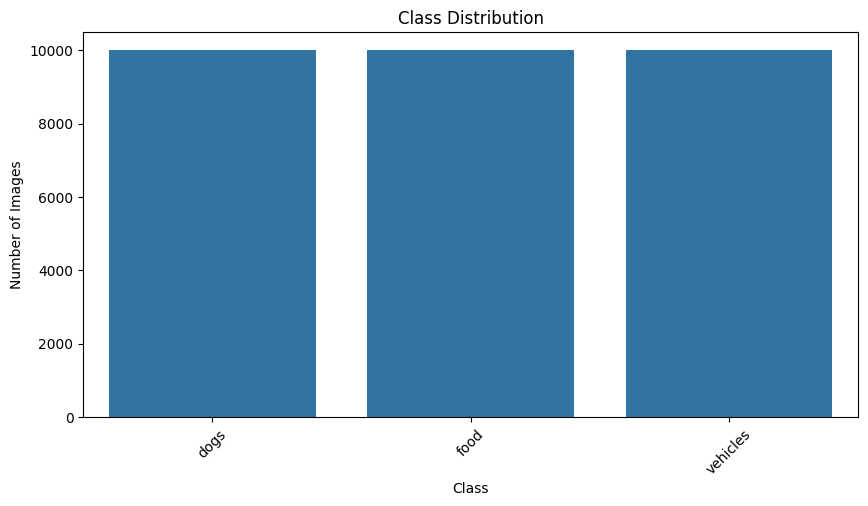

In [3]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Image Count', data=df)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


It gives us a quick look at how the dataset is distributed across three categories: dogs, food, and vehicles. Each class has about 10,000 images, meaning the dataset is well-balanced. That’s great news because it ensures no single category dominates the model’s learning process, helping it make fair and accurate predictions across all three groups.

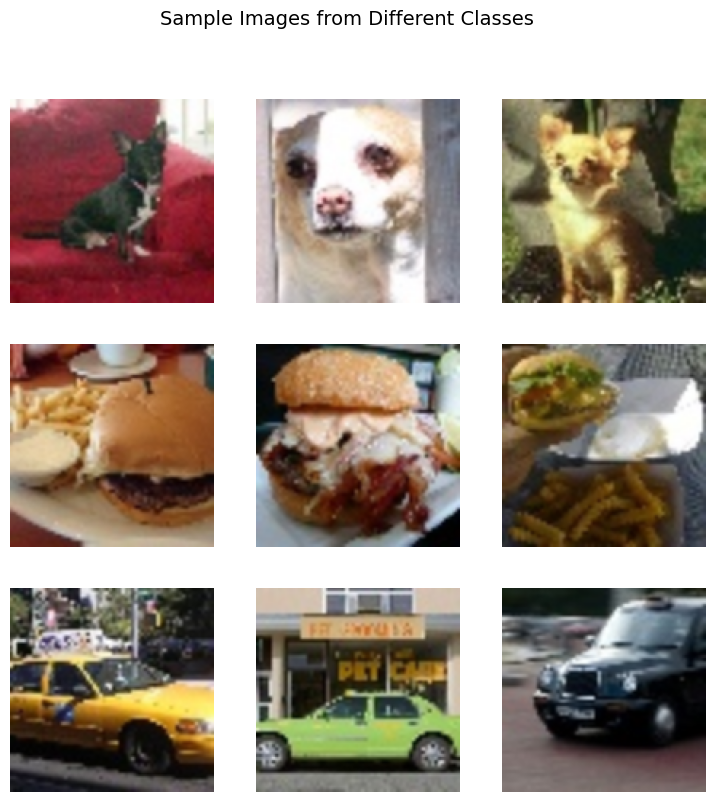

In [4]:
def show_images_grid(dataset, num_classes=3, samples_per_class=3):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    class_indices = {i: [] for i in range(len(class_names))}

    # Collect indices of images per class
    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)

    for row, (class_id, indices) in enumerate(class_indices.items()):
        if row >= num_classes:
            break
        for col, idx in enumerate(indices):
            img, _ = dataset[idx]
            img = img.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
            axes[row, col].imshow(img)
            axes[row, col].axis("off")
            if col == 0:
                axes[row, col].set_ylabel(class_names[class_id], fontsize=12)

    plt.suptitle("Sample Images from Different Classes", fontsize=14)
    plt.show()

show_images_grid(dataset)

This image grid gives us a quick sneak peek at the dataset, showing examples from three different categories: dogs, food, and vehicles. The top row has dogs, the middle row is all about burgers and fries, and the bottom row features different types of cars. This kind of visualization is super useful because it helps us make sure the images are clear, diverse, and properly labeled before we dive into training a model.

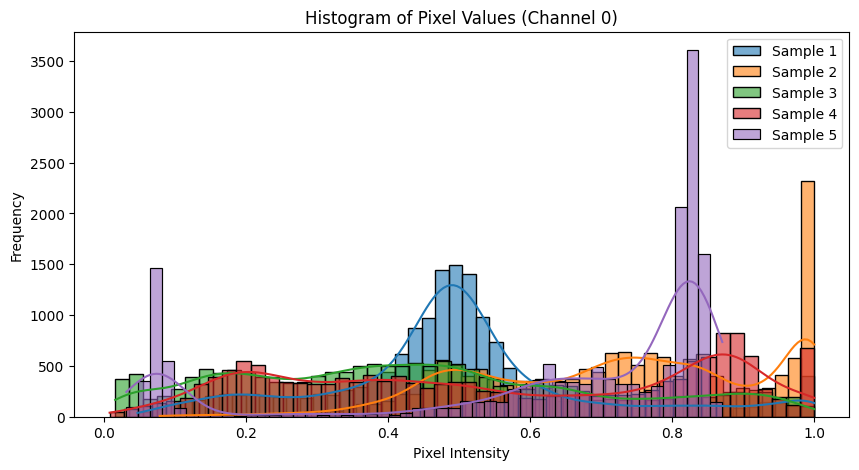

In [5]:
def plot_pixel_histogram(dataset, num_samples=5, channel=0):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        img, _ = dataset[i]
        img_np = img[channel].numpy().flatten()  # Get specified channel, flatten to 1D
        sns.histplot(img_np, bins=50, kde=True, alpha=0.6, label=f"Sample {i+1}")

    plt.title(f"Histogram of Pixel Values (Channel {channel})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_pixel_histogram(dataset)

It shows how pixel intensity values are distributed in the first color channel for five different image samples. Each sample has its own color, with bars representing how often certain intensity values appear. The smooth lines help show the overall trend of the data. You can see that some intensity levels are much more common than others, creating noticeable peaks. This gives a sense of the brightness patterns in the images and how they differ from one sample to another.

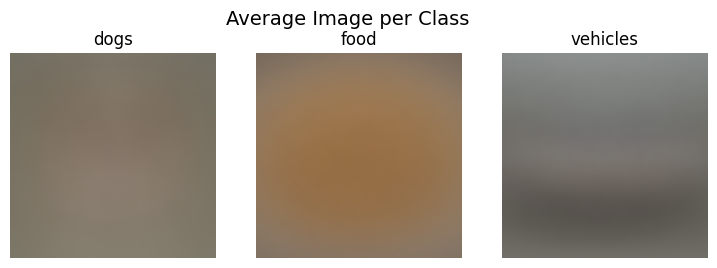

In [6]:
def compute_average_images(dataset):
    class_sums = {i: torch.zeros_like(dataset[0][0]) for i in range(len(class_names))}
    class_counts = Counter(dataset.targets)

    # Sum images per class
    for img, label in dataset:
        class_sums[label] += img

    # Compute average images
    class_averages = {label: (class_sums[label] / class_counts[label]) for label in class_sums}

    # Display the average images
    fig, axes = plt.subplots(1, len(class_averages), figsize=(len(class_averages) * 3, 3))
    for i, (label, avg_img) in enumerate(class_averages.items()):
        avg_img = avg_img.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        axes[i].imshow(avg_img)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")

    plt.suptitle("Average Image per Class", fontsize=14)
    plt.show()

compute_average_images(dataset)

This image gives a blurry, averaged-out look at what each category—dogs, food, and vehicles—tends to look like. By blending multiple images together, we lose the details but keep the overall colors and textures. You can see that food has a warmer, brownish tone, while vehicles lean toward grays.

In [7]:
# Convert target labels to integer tensors
targets = torch.LongTensor(dataset.targets)

In [8]:
indices = np.arange(len(dataset))
train_idx, test_val_idx = train_test_split(indices, test_size=0.3, stratify=dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_val_idx], random_state=42)

# Create subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 21000 images
Validation set: 4500 images
Test set: 4500 images


In [9]:
class VGG16ConfigC(nn.Module):
    """
    VGG-16 (Configuration C) adapted for smaller inputs (128x128).
    This config replaces one 3x3 conv with a 1x1 conv in blocks 3, 4, 5.
    """
    def __init__(self, num_classes=3):
        super(VGG16ConfigC, self).__init__()

        # Feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128 -> 64

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 -> 32

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),  # 1x1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 -> 16

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),  # 1x1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 -> 8

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),  # 1x1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 8 -> 4
        )

        # Classifier
        # After 5 max pools, our feature map is 512 x 4 x 4 for a 128x128 input
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x


In [10]:
def init_weights_xavier(m):
    """Apply Xavier/Glorot uniform initialization to Conv2d/Linear layers."""
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def init_weights_kaiming(m):
    """Apply He/Kaiming uniform initialization to Conv2d/Linear layers."""
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [11]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [12]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        # Step the scheduler (e.g., MultiStepLR, StepLR)
        scheduler.step()
        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")

        # Deep copy the model if it improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}\n")
    # Load best weights
    model.load_state_dict(best_model_wts)
    return model


In [14]:
def test_model(model, test_loader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

In [15]:
def create_dataloaders(batch_size):
    # Assumes that train_dataset, val_dataset, test_dataset are defined elsewhere.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(class_names)  # or manually set the number of classes
optimizers_list = ['SGD', 'Adam', 'AdamW']
batch_sizes = [32, 64]

results_xavier = []

print("Running experiments with Xavier weight initialization")
for opt_name in optimizers_list:
    for b_size in batch_sizes:
        print("=" * 60)
        print(f"Configuration: Weight Init = Xavier, Optimizer = {opt_name}, Batch Size = {b_size}")
        print("=" * 60)

        # Create dataloaders for the current batch size
        train_loader, val_loader, test_loader = create_dataloaders(b_size)

        # Instantiate model and apply Xavier weight initialization
        model = VGG16ConfigC(num_classes=num_classes).to(device)
        model.apply(init_weights_xavier)

        # Define loss, optimizer, and learning rate scheduler
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        elif opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)

        # Train the model and measure training time per epoch
        start_time = time.time()
        trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / 10  # using 30 as in your original logic
        print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")

        # Test the trained model
        test_acc = test_model(trained_model, test_loader, device)
        print("\n")

        # Save results for later analysis
        results_xavier.append({
            'weight_init': 'Xavier',
            'optimizer': opt_name,
            'batch_size': b_size,
            'avg_epoch_time': avg_epoch_time,
            'test_accuracy': test_acc.item()
        })

print("Summary of Xavier experiments:")
for res in results_xavier:
    print(res)

Using device: cuda
Running experiments with Xavier weight initialization
Configuration: Weight Init = Xavier, Optimizer = SGD, Batch Size = 32
Epoch 1/10
----------
Train Loss: 0.9741 Acc: 0.4785
Val   Loss: 0.7075 Acc: 0.6847

Epoch 2/10
----------
Train Loss: 0.5921 Acc: 0.7529
Val   Loss: 0.5203 Acc: 0.7893

Epoch 3/10
----------
Train Loss: 0.4785 Acc: 0.8117
Val   Loss: 0.4269 Acc: 0.8278

Epoch 4/10
----------
Train Loss: 0.3963 Acc: 0.8490
Val   Loss: 0.3385 Acc: 0.8667

Epoch 5/10
----------
Train Loss: 0.3427 Acc: 0.8674
Val   Loss: 0.5718 Acc: 0.8144

Epoch 6/10
----------
Train Loss: 0.3028 Acc: 0.8835
Val   Loss: 0.3182 Acc: 0.8758

Epoch 7/10
----------
Train Loss: 0.2870 Acc: 0.8901
Val   Loss: 0.2807 Acc: 0.8922

Epoch 8/10
----------
Train Loss: 0.2500 Acc: 0.9049
Val   Loss: 0.2679 Acc: 0.8964

Epoch 9/10
----------
Train Loss: 0.2279 Acc: 0.9121
Val   Loss: 0.2604 Acc: 0.9016

Epoch 10/10
----------
Train Loss: 0.2050 Acc: 0.9235
Val   Loss: 0.3192 Acc: 0.8980

Traini

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(class_names)  # or manually set the number of classes
optimizers_list = ['SGD', 'Adam', 'AdamW']
batch_sizes = [32, 64]

results_kaiming = []

print("Running experiments with Kaiming weight initialization")
for opt_name in optimizers_list:
    for b_size in batch_sizes:
        print("=" * 60)
        print(f"Configuration: Weight Init = Kaiming, Optimizer = {opt_name}, Batch Size = {b_size}")
        print("=" * 60)

        # Create dataloaders for the current batch size
        train_loader, val_loader, test_loader = create_dataloaders(b_size)

        # Instantiate model and apply Kaiming weight initialization
        model = VGG16ConfigC(num_classes=num_classes).to(device)
        model.apply(init_weights_kaiming)

        # Define loss, optimizer, and learning rate scheduler
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        elif opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)

        # Train the model and measure training time per epoch
        start_time = time.time()
        trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / 10  # using 30 as in your original logic
        print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")

        # Test the trained model
        test_acc = test_model(trained_model, test_loader, device)
        print("\n")

        # Save results for later analysis
        results_kaiming.append({
            'weight_init': 'Kaiming',
            'optimizer': opt_name,
            'batch_size': b_size,
            'avg_epoch_time': avg_epoch_time,
            'test_accuracy': test_acc.item()
        })

print("Summary of Kaiming experiments:")
for res in results_kaiming:
    print(res)

Using device: cuda
Running experiments with Kaiming weight initialization
Configuration: Weight Init = Kaiming, Optimizer = SGD, Batch Size = 32
Epoch 1/10
----------
Train Loss: 0.8916 Acc: 0.5618
Val   Loss: 0.6387 Acc: 0.7707

Epoch 2/10
----------
Train Loss: 0.5285 Acc: 0.7910
Val   Loss: 0.4518 Acc: 0.8247

Epoch 3/10
----------
Train Loss: 0.4446 Acc: 0.8250
Val   Loss: 0.5561 Acc: 0.7733

Epoch 4/10
----------
Train Loss: 0.3975 Acc: 0.8452
Val   Loss: 0.3718 Acc: 0.8569

Epoch 5/10
----------
Train Loss: 0.3533 Acc: 0.8656
Val   Loss: 0.3159 Acc: 0.8787

Epoch 6/10
----------
Train Loss: 0.3122 Acc: 0.8828
Val   Loss: 0.2914 Acc: 0.8862

Epoch 7/10
----------
Train Loss: 0.2756 Acc: 0.8962
Val   Loss: 0.2786 Acc: 0.8982

Epoch 8/10
----------
Train Loss: 0.2500 Acc: 0.9070
Val   Loss: 0.3721 Acc: 0.8653

Epoch 9/10
----------
Train Loss: 0.2374 Acc: 0.9110
Val   Loss: 0.2387 Acc: 0.9131

Epoch 10/10
----------
Train Loss: 0.2053 Acc: 0.9240
Val   Loss: 0.2359 Acc: 0.9149

Trai